# What's new in Lightkurve 2?

This page shows you what is new in Lightkurve v2. If you'd like to see our changelog, which tracks minor version changes and patches, you can [click here](https://docs.lightkurve.org/about/changelog.html).

## Lightkurve 2 offers improved support for TESS

Lightkurve v1 has been a tremendous success.  Owing to the efforts of [67 contributors](https://github.com/KeplerGO/lightkurve/blob/master/AUTHORS.rst), Lightkurve grew into a popular tool to analyze the data archive of NASA's Kepler space telescope.  The package has been cited by nearly [200 scientific publications](https://ui.adsabs.harvard.edu/search/q=full%3A"Lightkurve") to date.

In recent years, the success revealed a shortcoming: Lightkurve 1 was too focused on supporting Kepler data products. Over the past two years, our community has evolved in important ways:

* NASA successfully launched TESS, adding a significant new data set which requires Lightkurve-like tools.
* The TESS data archive started hosting numerous [community light curve databases](https://heasarc.gsfc.nasa.gov/docs/tess/community.html#high-level-science-products) created using specialized pipelines.
* Many new time domain missions are on the horizon, including NASA's Roman Space Telescope.

In response to these changes, the [TESS GI Office](https://heasarc.gsfc.nasa.gov/docs/tess/) at NASA Goddard and the [TESS Data Archive](https://archive.stsci.edu/tess/) at STScI/MAST supported the modification of Lightkurve and its tutorials to better support TESS and other data sets in three important ways:


1. LightCurve objects are now specialized kinds of AstroPy Table objects, making it a more generic container for light curves from any telescope.
2. Data search and download functions now support all TESS and Kepler light curve available at MAST, including those created by community pipelines.
3. The noise removal tools now allow users to perform custom corrections in a way that is very similar to the official TESS pipeline. 

The remainder of this page briefly demonstrates these new features.
They are explained in more detail in a new set of entry-level tutorials which are avaiable in the online documentation at [docs.lightkurve.org/tutorials](https://docs.lightkurve.org/tutorials).


## 1. LightCurve objects are now specialized kinds of AstroPy Tables

The most important change in Lightkurve 2 is that light curves are now extensions of AstroPy [TimeSeries](https://docs.astropy.org/en/stable/timeseries/) objects, which in turn are a sub-class of AstroPy Table.
Compared to a generic table, the key difference is that each `LightCurve` object is guaranteed to have `time`, `flux`, and `flux_err` columns. This allows Lightkurve to extend AstroPy with tools that are specific to the analysis of TESS-like time series photometry.

### ✨ New: LightCurve objects behave like tables

Light curves can still be created as before, but now look and act like tables:

In [1]:
from lightkurve import LightCurve
lc = LightCurve(time=[2000.0, 2000.1, 2000.2],
                flux=[1.0, 1.0, 1.0],
                flux_err=[0.1, 0.1, 0.1],
                time_format="btjd")
lc

time,flux,flux_err
,,
Time,float64,float64
2000.0,1.0,0.1
2000.1,1.0,0.1
2000.2,1.0,0.1


### ✨ New: Light curves support user-defined columns

Because light curves are now tables, they can contain arbitrary user-defined columns:

In [2]:
lc['color'] = ['red', 'green', 'blue']
lc

time,flux,flux_err,color
,,,
Time,float64,float64,str5
2000.0,1.0,0.1,red
2000.1,1.0,0.1,green
2000.2,1.0,0.1,blue


### ✨ New: Columns and rows can be accessed using index notation

Just like Table objects, columns and rows can be accessed using index notation:

In [3]:
lc[1:3]

time,flux,flux_err,color
,,,
Time,float64,float64,str5
2000.1,1.0,0.1,green
2000.2,1.0,0.1,blue


In [4]:
lc['flux']

<Quantity [1., 1., 1.]>

### ✨ New: Times are stored as an AstroPy Time object




Lightkurve 2 extends [AstroPy Time](https://docs.astropy.org/en/stable/time/) by adding support for the TESS and Kepler time formats ("BTJD" and "BKJD").  As a result, the time column is now always a Time object, which enables user to leverage this standard AstroPy feature:

In [5]:
lc.time

<Time object: scale='tdb' format='btjd' value=[2000.  2000.1 2000.2]>

In [6]:
lc.time.jd   # Easy conversion to Julian Days

array([2459000. , 2459000.1, 2459000.2])

In [7]:
lc.time.iso  # Easy conversion to ISO time stamps

array(['2020-05-30 12:00:00.000', '2020-05-30 14:24:00.000',
       '2020-05-30 16:48:00.000'], dtype='<U23')

### ✨ New: Read and write light curves in many file formats

Because light curves act like tables, they now have easy `read()` and `write()` methods which allow a [variety of data formats](https://docs.astropy.org/en/stable/io/unified.html#built-in-readers-writers) to be used.  For example, it is now much easier to store a light curve to a human-readable text file:

In [8]:
lc.write("/tmp/lightcurve.txt", format="ascii.fixed_width", overwrite=True)
!cat /tmp/lightcurve.txt

|   time | flux | flux_err | color |
| 2000.0 |  1.0 |      0.1 |   red |
| 2000.1 |  1.0 |      0.1 | green |
| 2000.2 |  1.0 |      0.1 |  blue |


In [9]:
LightCurve.read("/tmp/lightcurve.txt", format="ascii.fixed_width")

time,flux,flux_err,color
,,,
Time,float64,float64,str5
2000.0,1.0,0.1,red
2000.1,1.0,0.1,green
2000.2,1.0,0.1,blue


## 2. Search & download data from different pipelines

Lightkurve 2 significantly expands the data sets that can be searched and downloaded from the TESS & Kepler data archives at MAST.

### ✨ New: Search operations support different TESS pipelines

The search operations now support all the Kepler & TESS light curves available from the data archive at MAST, including community-contributed light curves. A new `author` column in the search results identifies the pipeline (click on a pipeline name for details). As an added bonus, the search and download operations are now *much* faster owing to improved caching.

In [10]:
import lightkurve as lk
lk.search_lightcurve("Polaris")

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 19,2019,SPOC,120,303256075,0.0
1,TESS Sector 19,2019,TESS-SPOC,1800,303256075,0.0
2,TESS Sector 19,2019,QLP,1800,303256075,0.0
3,TESS Sector 20,2019,QLP,1800,303256075,0.0
4,TESS Sector 25,2020,QLP,1800,303256075,0.0
5,TESS Sector 26,2020,QLP,1800,303256075,0.0
6,TESS Sector 26,2020,TASOC,1800,303256075,0.0
7,TESS Sector 26,2020,TASOC,1800,303256075,0.0
8,TESS Sector 40,2021,QLP,600,303256075,0.0


### ✨ New: Download TESS fast cadence data

The TESS mission recently introduced a new 20-second exposure time mode and decreased the exposure time of its Full Frame Images to 10 minutes.  In response, Lightkurve now allows user to specify the exact exposure time via the optional ``exptime`` argument and column.

In [11]:
lk.search_lightcurve("AU Mic", exptime=20)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 27,2020,SPOC,20,441420236,0.0


You can also filter search results after the fact via attribute access, e.g. via `search.exptime`:

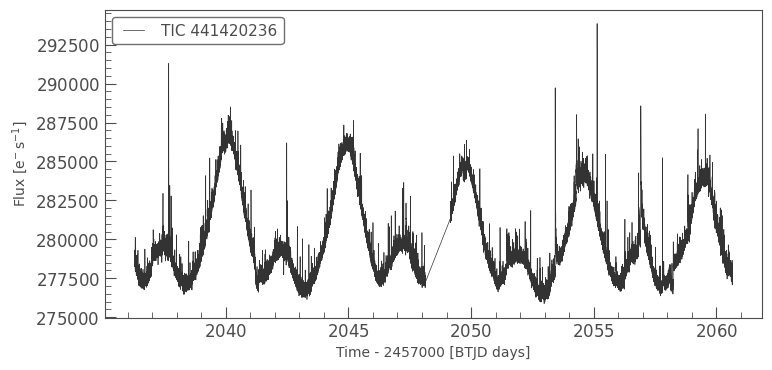

In [12]:
search = lk.search_lightcurve("AU Mic")
search[search.exptime.value == 20].download().plot();

## 3. New noise removal tools

### ✨ New: Remove systematics using Cotrending Basis Vectors

Lightkurve 2 adds a new `CotrendingBasisVectors` class to provide a convenient interface to work with the official TESS and Kepler basis vector data products. We also re-implemented the `CBVCorrector` class from scratch to perform the correction in a way that is more similar to the official Kepler/TESS pipeline. This work was led by one of the authors of the official pipeline, Jeff Smith.

In [13]:
# Download a light curve and apply the new CBVCorrector
from lightkurve.correctors import CBVCorrector
lc = lk.search_lightcurve("TIC 99180739", author="SPOC", sector=10).download(flux_column="sap_flux")
cbvCorrector = CBVCorrector(lc)
lc_corrected = cbvCorrector.correct()

Optimized Over-fitting metric: 0.9996600990374926
Optimized Under-fitting metric: 0.825582260216318
Optimized Alpha: 9.625e+03


The corrector now produces detailed diagnostic plots showing the light curve before (grey) and after (black) the noise (blue) was removed:

In [14]:
cbvCorrector.diagnose();

### ✨ New: Remove systematics by optimizing under- and over-fitting metrics

A `lightkurve.correctors.metrics` module was added to provide functions which can estimate the degree of over- and under-fitting of a corrected light curve. The new `CBVCorrector` utilizes these metrics to find an appropriate, user-tuneable tradeoff. You can learn more about this new feature in the [new CBVCorrector tutorial](tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html).

In [15]:
cbvCorrector.goodness_metric_scan_plot();

### ✨ New: Inspect pixel-by-pixel light curves using *plot_pixels()*

A new ``TargetPixelFile.plot_pixels()`` method has been added which enables the light curves and periodograms of individual pixels to be inspected within a pixel file. This is very useful for investigating the location of specific signals. A [dedicated tutorial](tutorials/3-science-examples/periodograms-verifying-the-location-of-a-signal.html) explains this new feature in detail.

In [16]:
pixelfile = lk.search_targetpixelfile("KIC 2435971", mission="Kepler", quarter=9).download()
pixelfile.plot_pixels();

## Other changes

* Support for Python 2 has been removed.
* The [online documentation](https://docs.lightkurve.org) has been updated to provide numerous new tutorials and a more comprehensive API reference guide.
* Search and download operations are now cached in a more robust way, significantly speeding up accessing data from MAST. 
* Added a column parameter to LightCurve's plot(), scatter(), and errorbar() methods to enable any column in a light curve object to be plotted. 
* Added the `LightCurve.create_transit_mask(period, transit_time, duration)` method to conveniently mask planet or eclipsing binary transits. 
* Added the `LightCurve.search_neighbors()` method to search for light curves around an existing one. 
* Modified `TargetPixelFile.plot()` to use a more clear hatched style when visualizing the aperture mask on top of pixel data. 
* Added `SparseDesignMatrix` and modified `RegressionCorrector` to enable systematics removal methods to benefit from scipy.sparse speed-ups. 

In addition, Lightkurve 2 contains numerous smaller improvements and bugfixes. To see a detailed list of all changes, please see the [Full Changelog](http://docs.lightkurve.org/about/changelog.html).

## FAQ

### How do I install Lightkurve 2?

You can upgrade Lightkurve using pip:

```
python -m pip install --upgrade lightkurve
```

### How do I keep using Lightkurve 1?

You can continue to use Lightkurve 1 by pinning the version number using pip, for example:

```
python -m pip install lightkurve==1.11
```

### Will existing Lightkurve code break?

While we tried to maximize backwards compatibility, Lightkurve 2 does contain a small number of changes that may break existing code for the following reasons:

1. **lc.time is now always an Astropy Time object.**  Unfortunately, many NumPy and SciPy functions do not deal seamlessly with `Time` objects yet. Existing code may have to be modified to pass `lc.time.value` to NumPy/SciPy functions where `lc.time` was passed before.
2. **Other numerical columns are now Astropy Quantity objects.**  While Quantity objects are largely compatible with NumPy/SciPy, situations do arise where users may wish to perform operations on `lc.flux.value` instead of `lc.flux`.
3. **All metadata is now stored in the lc.meta dictionary**.  This includes any header values of the FITS file from which a light curve was loaded.  For convenience, we continue to support attribute access, e.g. `lc.sector` is available as a shortcut for `lc.meta['SECTOR']`.
4. **LightCurveFile classes have been deprecated.** Instead, light curve files can now be loaded using `LightCurve.read(filename, format="tess")`.
5. **lc.time can no longer contain NaN values**.  This is because AstroPy Time objects do not currently support NaN values. As a result, light curve reading functions will tend to ignore rows with NaN time values. All other columns in a light curve continue to support NaNs values however.
6. **lc.bin() now takes time_bin_size and time_bin_start arguments.** This is for consistency with `astropy.timeseries.aggregate_downsample`. This significantly alters the behavior of binning, because bins are now defined in time instead of by number of data points.
7. **lc.fold() now returns un-normalized phase values by default.**  This is for consistency with `TimeSeries.fold()`. For the same reason, the `t0` argument has been deprecated in favor of `epoch_time`, and the method now accepts the extra `epoch_phase`, `wrap_phase`, and `normalize_phase` arguments.
8. **Several attributes and methods have been deprecated.**  They still work but will yield a warning and may be removed in the future:
  * `lc.astropy_time` => `lc.time`
  * `lc.time_format` => `lc.time.format`
  * `lc.time_scale` => `lc.time.scale`
  * `lc.flux_quantity` => `lc.flux`
  * `lc.flux_unit` => `lc.flux.unit`
  * `search_lightcurvefile()` => `search_lightcurve()`

## Contributors

The people who contributed to Lightkurve 2 include:

Thomas Barclay, Geert Barentsen, Keaton Bell, Zachory K. Berta-Thompson, Colin J. Burke, Nuno Ramos Carvalho, Ann Marie Cody, Isabel Coleman, Kaiming Cui, Guy Davies, Jessie Dotson, Stephanie Douglas, Scott Fleming, Daniel Foreman-Mackey, Michael Gully-Santiago, Oliver Hall, Christina Hedges, Daniel Hey, Michael Higgins, Derek Homeier, Rebekah Hounsell, Sam Lee, Jose A. Lerma III, Ken Mighell, Susan Mullally, Szabo Pal, Sheila Sagear, Nicholas Saunders, Jeff Smith, Anand Sundaram, Emma Turtelboom, Andrew Vanderburg, Brennan Vincello, José Vinícius de Miranda Cardoso, Peter Williams, Johnny Zhang.